# Bike Share Assignment - Question 3 and 4

Ufuk Taner CEYHANLLI

## Introduction
I am going to predict the number of borrowed bikes **in a given day and station** by using 4 available data set below.

- station.csv - Contains data that represents a station where users can pick up or return bikes.
- status.csv - Data about the number of bikes and docks available for a given station and minute.
- trips.csv - Data about individual bike trips.
- weather.csv - Data about the weather on a specific day for specific station id. 

Answers of the question 3 and 4 are at end of the notebook.

## Hypothesis Generation

What could effect the people to rent a bike?

- Number of bikes
- Condition of the bikes
- Availablity of the bike roads around the station
- Daily Trend: weekdays as compared to weekend or holiday
- Hourly trend: office timings. Early morning and late evening 
- Rain: The demand of bikes will be lower on a rainy day as compared to a sunny day
- Temperature: I presume it may have positive correlation
- Pollution: government / company policies
- Traffic: Higher traffic may force people to use bike as compared to others

## Understanding the Data Set and EDA

I've already performed EDA on the data sets, you can access it via this [link](https://tanerceyhanli.github.io/Bike-Share-Assignment).

EDA outcomes and hypothesis testing

- There is a daily trend
- There is a hourly trend
- Seasonal trend


### Install Necessary Packages

In [7]:
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, median_absolute_error
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

### Loading Data Sets

In [8]:
df_trip = pd.read_csv("trip.csv")
df_station = pd.read_csv("station.csv")
df_weather = pd.read_csv("weather.csv")

### Station Data Set

In [9]:
df_station

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013
...,...,...,...,...,...,...,...
65,77,Market at Sansome,37.789625,-122.400811,27,San Francisco,8/25/2013
66,80,Santa Clara County Civic Center,37.352601,-121.905733,15,San Jose,12/31/2013
67,82,Broadway St at Battery St,37.798541,-122.400862,15,San Francisco,1/22/2014
68,83,Mezes Park,37.491269,-122.236234,15,Redwood City,2/20/2014


In [10]:
len(df_station.id.unique())

70

#### There are 70 different stations.

### Trip Data Set

In [11]:
# Have a look at first 5 instance
df_trip.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [12]:
# Number of instance and variables
df_trip.shape

(669959, 11)

In [13]:
# Checking for Missing Values
df_trip.isnull().sum()

id                       0
duration                 0
start_date               0
start_station_name       0
start_station_id         0
end_date                 0
end_station_name         0
end_station_id           0
bike_id                  0
subscription_type        0
zip_code              6619
dtype: int64

In [14]:
#Check dtypes
df_trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669959 entries, 0 to 669958
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   id                  669959 non-null  int64 
 1   duration            669959 non-null  int64 
 2   start_date          669959 non-null  object
 3   start_station_name  669959 non-null  object
 4   start_station_id    669959 non-null  int64 
 5   end_date            669959 non-null  object
 6   end_station_name    669959 non-null  object
 7   end_station_id      669959 non-null  int64 
 8   bike_id             669959 non-null  int64 
 9   subscription_type   669959 non-null  object
 10  zip_code            663340 non-null  object
dtypes: int64(5), object(6)
memory usage: 56.2+ MB


In [15]:
#Create a new variable date from start_date
df_trip['date'] = df_trip.start_date
df_trip.date = pd.to_datetime(df_trip.start_date, format='%m/%d/%Y %H:%M')
df_trip['date'] = pd.to_datetime(df_trip['date'])

In [16]:
# Summary statistics
df_trip.describe()

,id,duration,start_station_id,end_station_id,bike_id
count,669959.000000,6.699590e+05,669959.000000,669959.000000,669959.000000
mean,460382.009899,1.107950e+03,57.851876,57.837438,427.587620
std,264584.458487,2.225544e+04,17.112474,17.200142,153.450988
min,4069.000000,6.000000e+01,2.000000,2.000000,9.000000
25%,231082.500000,3.440000e+02,50.000000,50.000000,334.000000
50%,459274.000000,5.170000e+02,62.000000,62.000000,440.000000
75%,692601.000000,7.550000e+02,70.000000,70.000000,546.000000
max,913460.000000,1.727040e+07,84.000000,84.000000,878.000000


### Weather

In [17]:
df_weather

,date,start_station_id,zip_code,mean_temperature_f,min_temperature_f,mean_humidity,max_humidity,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,max_gust_speed_mph,precipitation_inches,events
0,2013-08-29,27,94107,68.0,61.0,75.0,93.0,10.0,10.0,23.0,28.0,0.0,NaN
1,2013-08-29,39,94107,68.0,61.0,75.0,93.0,10.0,10.0,23.0,28.0,0.0,NaN
2,2013-08-29,41,94107,68.0,61.0,75.0,93.0,10.0,10.0,23.0,28.0,0.0,NaN
3,2013-08-29,47,94107,68.0,61.0,75.0,93.0,10.0,10.0,23.0,28.0,0.0,NaN
4,2013-08-29,48,94107,68.0,61.0,75.0,93.0,10.0,10.0,23.0,28.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52038,2015-08-31,71,94109,70.8,60.2,63.8,82.2,11.4,9.8,19.0,22.5,0.0,NaN
52039,2015-08-31,66,94103,70.8,60.2,63.8,82.2,11.4,9.8,19.0,22.5,0.0,NaN
52040,2015-08-31,67,94103,70.8,60.2,63.8,82.2,11.4,9.8,19.0,22.5,0.0,NaN
52041,2015-08-31,72,94103,70.8,60.2,63.8,82.2,11.4,9.8,19.0,22.5,0.0,NaN


In [18]:
df_weather.events.unique()

array([nan, 'Fog', 'Rain', 'Fog-Rain', 'rain', 'Rain-Thunderstorm'],
      dtype=object)

In [19]:
df_weather.loc[df_weather.events == 'rain', 'events'] = "Rain"
df_weather.loc[df_weather.events.isnull(), 'events'] = "Normal"

In [20]:
df_weather.isnull().sum()

date                       0
start_station_id           0
zip_code                   0
mean_temperature_f         0
min_temperature_f          5
mean_humidity              0
max_humidity             105
mean_visibility_miles      0
min_visibility_miles      26
max_wind_Speed_mph         0
max_gust_speed_mph         2
precipitation_inches     252
events                     0
dtype: int64

In [21]:
#Fill null cells with lambda
df_weather = df_weather.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [22]:
df_weather.isnull().sum()

date                     0
start_station_id         0
zip_code                 0
mean_temperature_f       0
min_temperature_f        0
mean_humidity            0
max_humidity             0
mean_visibility_miles    0
min_visibility_miles     0
max_wind_Speed_mph       0
max_gust_speed_mph       0
precipitation_inches     0
events                   0
dtype: int64

## Data Preparation

- Prepare data set for prediction based on df_trip dataframe
- Drop unnecessary variables
- Data set should countain date and total number of daily trips from each stations
- Day,Mount,Year,Weekday,Holiday,Season variables need to be added
- Station data should be merged
- Weather data should be merged

In [23]:
#Drop unnecessary variables
df= df_trip.drop(['id','duration','start_date','start_station_name','end_date', 'end_station_name','end_station_id','bike_id','subscription_type', 'zip_code'], 1)

In [24]:
#Number of trips variable
df['date'] = df.date.dt.date
df = df.value_counts().to_frame('no_of_trips').reset_index()

#Sort by date
df = df.sort_values(by=['date'])
df.reset_index(drop=True, inplace=True)

df.head()

,start_station_id,date,no_of_trips
0,22,2013-08-29,5
1,13,2013-08-29,4
2,30,2013-08-29,1
3,49,2013-08-29,18
4,55,2013-08-29,6


In [25]:
# We will make daily predictions, hours is not important
df['year'] = df_trip['date'].dt.year
df['month'] = df_trip['date'].dt.month
df['day'] = df_trip['date'].dt.day

# Variables added
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43270 entries, 0 to 43269
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   start_station_id  43270 non-null  int64 
 1   date              43270 non-null  object
 2   no_of_trips       43270 non-null  int64 
 3   year              43270 non-null  int64 
 4   month             43270 non-null  int64 
 5   day               43270 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 2.0+ MB


In [26]:
#Day name of the week
df['date'] = pd.to_datetime(df['date'])
df['day_name'] = df['date'].dt.day_name()

In [27]:
#Weekend
df['weekend'] = df['weekend'] = df['date'].dt.dayofweek > 4
df['weekend'] = df['weekend'].astype(object)

In [28]:
#Season variable
df['season'] = (df['date'].dt.month%12 + 3)//3

seasons = {
             1: 'Winter',
             2: 'Spring',
             3: 'Summer',
             4: 'Autumn'
}

df['season'] = df['season'].map(seasons)

In [29]:
#Find holidays
cal = calendar()
dr = pd.date_range(start='2013-07-01', end='2016-07-31')
holidays = cal.holidays(start=dr.min(), end=dr.max())

In [30]:
#Holiday variable
df['holiday'] = df['date'].dt.date.astype('datetime64').isin(holidays)
df['holiday'] = df['holiday'].astype(object)

In [34]:
# allign dtypes before merge
df['date'] = pd.to_datetime(df['date'])
df_station['installation_date'] = pd.to_datetime(df_station['installation_date'])
df_weather['date'] = pd.to_datetime(df_weather['date'])

In [40]:
#merge trips and station data
no_of_docks = []
for day in df.date:
    no_of_docks.append(sum(df_station[df_station.installation_date <= day].dock_count))
    
df['no_of_docks'] = no_of_docks

In [42]:
#merge trips and weather data
df = pd.merge(df, df_weather, on=['start_station_id','date'], how='left')

df.head()

,start_station_id,date,no_of_trips,year,month,day,day_name,weekend,season,holiday,...,mean_temperature_f,min_temperature_f,mean_humidity,max_humidity,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,max_gust_speed_mph,precipitation_inches,events
0,22,2013-08-29,5,2013,8,29,Thursday,False,Summer,False,...,71.0,62.0,79.0,94.0,10.0,10.0,14.0,17.0,0.0,Normal
1,13,2013-08-29,4,2013,8,29,Thursday,False,Summer,False,...,70.4,62.8,73.2,88.8,10.0,10.0,17.8,21.6,0.0,Normal
2,30,2013-08-29,1,2013,8,29,Thursday,False,Summer,False,...,70.4,62.8,73.2,88.8,10.0,10.0,17.8,21.6,0.0,Normal
3,49,2013-08-29,18,2013,8,29,Thursday,False,Summer,False,...,70.4,62.8,73.2,88.8,10.0,10.0,17.8,21.6,0.0,Normal
4,55,2013-08-29,6,2013,8,29,Thursday,False,Summer,False,...,70.4,62.8,73.2,88.8,10.0,10.0,17.8,21.6,0.0,Normal


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43270 entries, 0 to 43269
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   start_station_id       43270 non-null  int64         
 1   date                   43270 non-null  datetime64[ns]
 2   no_of_trips            43270 non-null  int64         
 3   year                   43270 non-null  int64         
 4   month                  43270 non-null  int64         
 5   day                    43270 non-null  int64         
 6   day_name               43270 non-null  object        
 7   weekend                43270 non-null  object        
 8   season                 43270 non-null  object        
 9   holiday                43270 non-null  object        
 10  no_of_docks            43270 non-null  int64         
 11  zip_code               43270 non-null  int64         
 12  mean_temperature_f     43270 non-null  float64       
 13  m

## Feature Engineering

### Standard Scaler for continous variables

In [46]:
scaler = StandardScaler()
df[['no_of_docks','mean_temperature_f', 'min_temperature_f', 'mean_humidity', 'max_humidity','mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph', 'max_gust_speed_mph','max_gust_speed_mph']]=scaler.fit_transform(df[['no_of_docks','mean_temperature_f', 'min_temperature_f', 'mean_humidity', 'max_humidity','mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph', 'max_gust_speed_mph','max_gust_speed_mph']].to_numpy())
df

,start_station_id,date,no_of_trips,year,month,day,day_name,weekend,season,holiday,...,mean_temperature_f,min_temperature_f,mean_humidity,max_humidity,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,max_gust_speed_mph,precipitation_inches,events
0,22,2013-08-29,5,2013,8,29,Thursday,False,Summer,False,...,1.431242,1.424143,1.100845,1.025795,0.214677,0.695694,-0.568521,-0.581315,0.0,Normal
1,13,2013-08-29,4,2013,8,29,Thursday,False,Summer,False,...,1.342652,1.539740,0.542780,0.393064,0.214677,0.695694,0.117123,0.001171,0.0,Normal
2,30,2013-08-29,1,2013,8,29,Thursday,False,Summer,False,...,1.342652,1.539740,0.542780,0.393064,0.214677,0.695694,0.117123,0.001171,0.0,Normal
3,49,2013-08-29,18,2013,8,29,Thursday,False,Summer,False,...,1.342652,1.539740,0.542780,0.393064,0.214677,0.695694,0.117123,0.001171,0.0,Normal
4,55,2013-08-29,6,2013,8,29,Thursday,False,Summer,False,...,1.342652,1.539740,0.542780,0.393064,0.214677,0.695694,0.117123,0.001171,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43265,9,2015-08-31,2,2013,10,17,Monday,False,Summer,False,...,1.401712,1.164050,-0.361670,-0.410016,1.472286,0.619260,0.333642,0.115136,0.0,Normal
43266,7,2015-08-31,2,2013,10,17,Monday,False,Summer,False,...,1.401712,1.164050,-0.361670,-0.410016,1.472286,0.619260,0.333642,0.115136,0.0,Normal
43267,22,2015-08-31,5,2013,10,17,Monday,False,Summer,False,...,1.431242,1.424143,-0.053772,-1.042746,0.214677,0.695694,0.153210,-0.201433,0.0,Normal
43268,77,2015-08-31,49,2013,10,17,Monday,False,Summer,False,...,1.135943,1.135151,-0.053772,-0.190994,0.214677,0.313523,0.153210,-0.074805,0.0,Normal


### One hot encoding for categorical variables

In [47]:

# Making dummy variables for categorical data with more inputs.  
data_dummy = pd.get_dummies(df[['day_name','weekend','season', 'holiday', 'events']])

# Output the first five rows.
data_dummy.head()


,day_name_Friday,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday,weekend_False,weekend_True,season_Autumn,season_Spring,season_Summer,season_Winter,holiday_False,holiday_True,events_Fog,events_Fog-Rain,events_Normal,events_Rain,events_Rain-Thunderstorm
0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
2,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
3,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
4,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0


In [48]:
# Merging (concatenate) original data frame with 'dummy' dataframe.
df = pd.concat([df,data_dummy], axis=1)

In [49]:
# Dropping attributes for which we made dummy variables and zip_code
df = df.drop(['day_name','weekend','season', 'holiday', 'events','zip_code'], axis=1)
df.head()

,start_station_id,date,no_of_trips,year,month,day,no_of_docks,mean_temperature_f,min_temperature_f,mean_humidity,...,season_Spring,season_Summer,season_Winter,holiday_False,holiday_True,events_Fog,events_Fog-Rain,events_Normal,events_Rain,events_Rain-Thunderstorm
0,22,2013-08-29,5,2013,8,29,-2.172486,1.431242,1.424143,1.100845,...,0,1,0,1,0,0,0,1,0,0
1,13,2013-08-29,4,2013,8,29,-2.172486,1.342652,1.539740,0.542780,...,0,1,0,1,0,0,0,1,0,0
2,30,2013-08-29,1,2013,8,29,-2.172486,1.342652,1.539740,0.542780,...,0,1,0,1,0,0,0,1,0,0
3,49,2013-08-29,18,2013,8,29,-2.172486,1.342652,1.539740,0.542780,...,0,1,0,1,0,0,0,1,0,0
4,55,2013-08-29,6,2013,8,29,-2.172486,1.342652,1.539740,0.542780,...,0,1,0,1,0,0,0,1,0,0


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43270 entries, 0 to 43269
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   start_station_id          43270 non-null  int64         
 1   date                      43270 non-null  datetime64[ns]
 2   no_of_trips               43270 non-null  int64         
 3   year                      43270 non-null  int64         
 4   month                     43270 non-null  int64         
 5   day                       43270 non-null  int64         
 6   no_of_docks               43270 non-null  float64       
 7   mean_temperature_f        43270 non-null  float64       
 8   min_temperature_f         43270 non-null  float64       
 9   mean_humidity             43270 non-null  float64       
 10  max_humidity              43270 non-null  float64       
 11  mean_visibility_miles     43270 non-null  float64       
 12  min_visibility_mil

## Model Building

In [60]:
labels = df.no_of_trips
train = df.drop(['no_of_trips', 'date'], 1)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.3, random_state = 2)

#### Random Forest Regressor

In [68]:
rfr = RandomForestRegressor(n_estimators = 55,
                            min_samples_leaf = 3,
                            random_state = 2)
rfr = rfr.fit(X_train, y_train)

#### Ada Boost Regressor

In [69]:
abr = AdaBoostRegressor(n_estimators = 100,
                        learning_rate = 0.1,
                        loss = 'linear',
                        random_state = 2)

#### GradientBoostingRegressor

In [72]:
gbr = GradientBoostingRegressor(learning_rate = 0.12,
                                n_estimators = 55,
                                max_depth = 5,
                                min_samples_leaf = 1,
                                random_state = 2)

### Scoring the Models

In [73]:
scoring = ['r2','neg_mean_squared_error','neg_mean_absolute_error']
models = [rfr,abr,gbr]

for model in models:
    for i in scoring:
        scores = cross_val_score( model, X_train, y_train, cv=5, scoring = i)
    #    print(scores)
        if i == 'r2':
            print(model, i, ': ', scores.mean())
        elif i == 'neg_mean_squared_error':    
            x = -1*scores.mean()
            y = math.sqrt(x) 
            print(model, 'RMSE: ', "%0.2f" % y)
        elif i == 'neg_mean_absolute_error':
            x = -1*scores.mean()
            print(model,i, ": %0.2f (+/- %0.2f)" % (x, scores.std() * 2))   

RandomForestRegressor(min_samples_leaf=3, n_estimators=55, random_state=2) r2 :  0.9044197040603394
RandomForestRegressor(min_samples_leaf=3, n_estimators=55, random_state=2) RMSE:  5.50
RandomForestRegressor(min_samples_leaf=3, n_estimators=55, random_state=2) neg_mean_absolute_error : 3.43 (+/- 0.05)
AdaBoostRegressor(learning_rate=0.1, n_estimators=100, random_state=2) r2 :  0.6341505914850414
AdaBoostRegressor(learning_rate=0.1, n_estimators=100, random_state=2) RMSE:  10.76
AdaBoostRegressor(learning_rate=0.1, n_estimators=100, random_state=2) neg_mean_absolute_error : 7.59 (+/- 0.40)
GradientBoostingRegressor(learning_rate=0.12, max_depth=5, n_estimators=55,
                          random_state=2) r2 :  0.8730648000696846
GradientBoostingRegressor(learning_rate=0.12, max_depth=5, n_estimators=55,
                          random_state=2) RMSE:  6.34
GradientBoostingRegressor(learning_rate=0.12, max_depth=5, n_estimators=55,
                          random_state=2) neg_mean_abs

In [75]:
#Fit and predict with the best model
rfr = rfr.fit(X_train, y_train)
rfr_preds = rfr.predict(X_test)

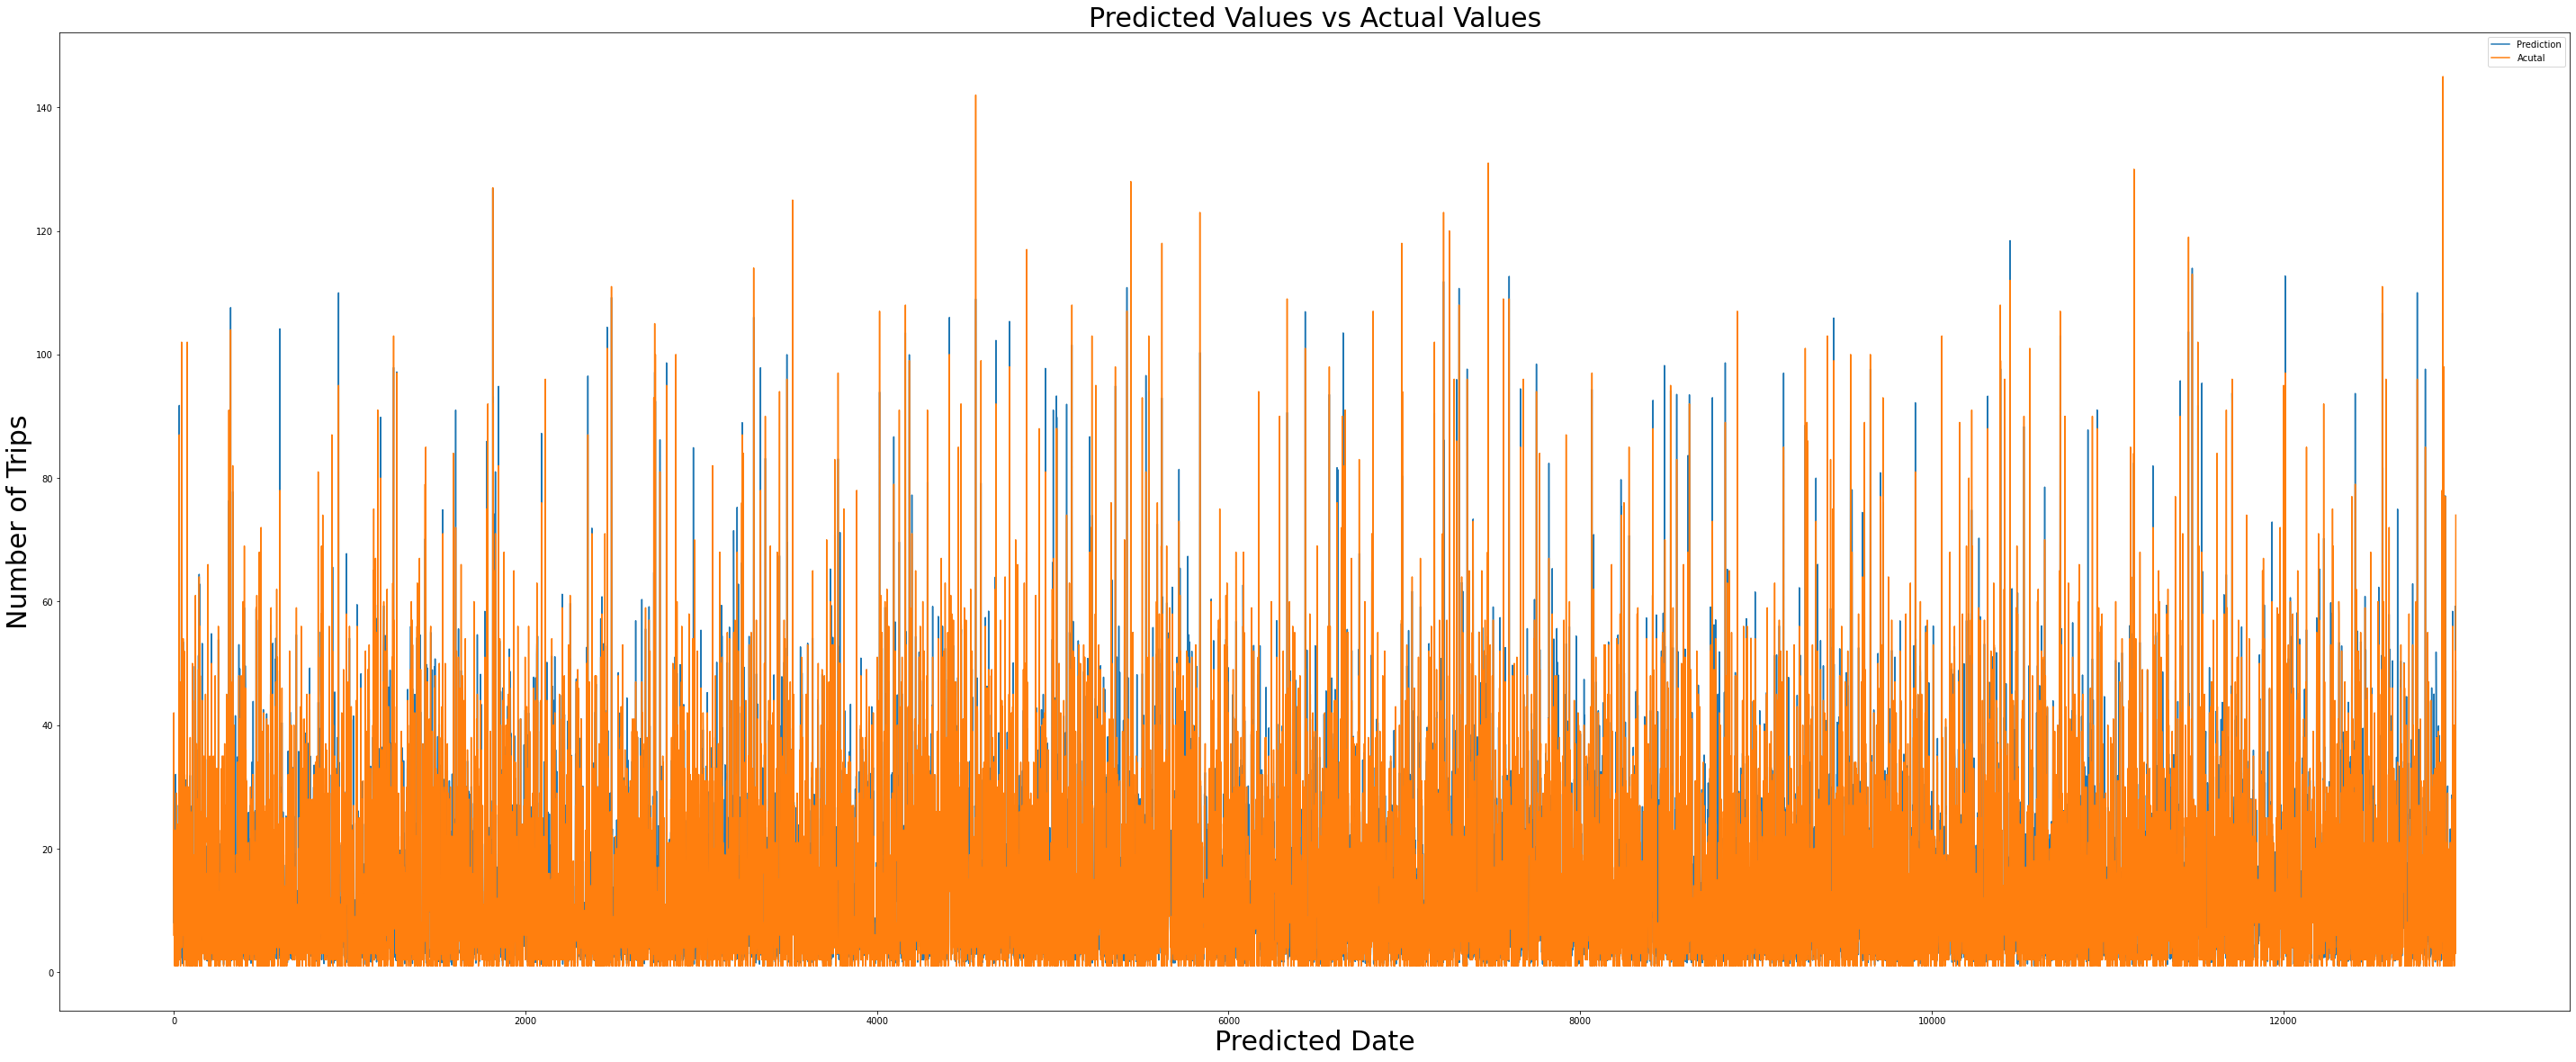

In [76]:
#Visualize
y_test.reset_index(drop = True, inplace = True)
fs = 30
plt.figure(figsize=(50,20))
plt.plot(rfr_preds)
plt.plot(y_test)
plt.legend(['Prediction', 'Acutal'])
plt.ylabel("Number of Trips", fontsize = fs)
plt.xlabel("Predicted Date", fontsize = fs)
plt.title("Predicted Values vs Actual Values", fontsize = fs)
plt.show()

Feature ranking:
0 start_station_id
1 year
2 month
3 day
4 no_of_docks
5 mean_temperature_f
6 min_temperature_f
7 mean_humidity
8 max_humidity
9 mean_visibility_miles
10 min_visibility_miles
11 max_wind_Speed_mph
12 max_gust_speed_mph
13 precipitation_inches
14 day_name_Friday
15 day_name_Monday
16 day_name_Saturday
17 day_name_Sunday
18 day_name_Thursday
19 day_name_Tuesday
20 day_name_Wednesday
21 weekend_False
22 weekend_True
23 season_Autumn
24 season_Spring
25 season_Summer
26 season_Winter
27 holiday_False
28 holiday_True
29 events_Fog
30 events_Fog-Rain
31 events_Normal
32 events_Rain
33 events_Rain-Thunderstorm


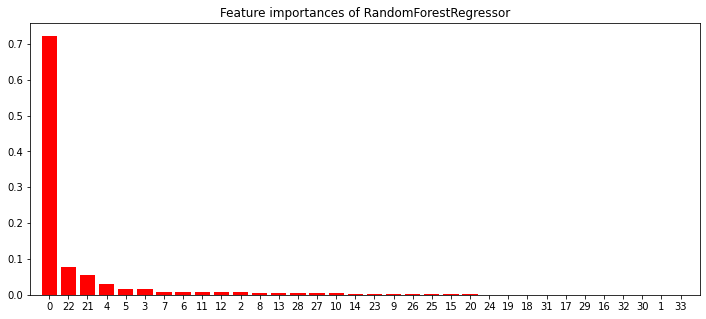

In [78]:
#Features by importance
def plot_importances(model, model_name):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for feature in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]    

    # Plot the feature importances of the forest
    plt.figure(figsize = (12,5))
    plt.title("Feature importances of " + model_name)
    plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

print("Feature ranking:")

i = 0
for feature in X_train:
    print (i, feature)
    i += 1
    
plot_importances(rfr, "RandomForestRegressor")

#### Q3.Can you predict the demand for bikes in a given station day in advance? 
If yes, what arethe main factors contributing to the predictions? Would this model be actionable to
business? The model should be basic, the only requirement is that it should be
interpretable.

#### A3.Yes
Station, weekend, number of docks, mean_temperature, day.
If this model is improved, it can be actionable to business.
Bike and docks number can be increased for the station which the prediction model interprets the demand will be higher.
Or, for the stations with low number predicted demand may be considered to close down.

#### Q4.Something to think about for the interview: What are 3 additional pieces of information you would recommend to add to these datasets to gain more insight into the business and usage of this product?

#### A4

- Condition of the bikes
- Population in the region of the station
- Traffic data
- Availablity of the bike roads in the region of the station
- Polution
- Average bike prices in the region